In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchsummary import summary
from torchmetrics import JaccardIndex

import time
import copy
import os

In [2]:
data_dir = '../../../../IIT/IIT Sem 7/IE 643/Challenge_Dataset/Images'
mask_dir = '../../../../IIT/IIT Sem 7/IE 643/Challenge_Dataset/Masks'

In [3]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ColorJitter(),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((128,128)),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
}
mask_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])
}

In [4]:
class ImageMaskDataset(Dataset):
    def __init__(self, data_dir, mask_dir, train = True, transform = None, mask_transform = None) -> None:
        super(ImageMaskDataset, self).__init__()
        self.imgs = []
        self.transform = transform
        if train:
            for file1 in os.scandir(data_dir+'/Train'):
                file2 = mask_dir+'/Train/'+file1.name[:-3]+'png'
                if self.transform is not None:
                    self.imgs.append((self.transform(Image.open(file1.path).convert('RGB')),mask_transform(Image.open(file2))))
                else:
                    self.imgs.append((Image.open(file1.path).convert('RGB'),Image.open(file2)))
        else:
            for file1 in os.scandir(data_dir+'/Validation'):
                file2 = mask_dir+'/Validation/'+file1.name[:-3]+'png'
                if self.transform is not None:
                    self.imgs.append((self.transform(Image.open(file1.path).convert('RGB')),mask_transform(Image.open(file2))))
                else:
                    self.imgs.append((Image.open(file1.path).convert('RGB'),Image.open(file2)))
                    # if self.imgs[-1][0].shape[0] == 1:
                    #     self.imgs[-1] = (self.imgs[-1][0].repeat(3,1,1), self.imgs[-1][1])
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        return self.imgs[index]

In [5]:
train_data = ImageMaskDataset(data_dir, mask_dir, train = True, transform=data_transforms['Train'], mask_transform=mask_transforms['Train'])
val_data = ImageMaskDataset(data_dir, mask_dir, train = False, transform=data_transforms['Validation'], mask_transform=mask_transforms['Validation'])

In [6]:
train_loader = DataLoader(
    train_data,
    batch_size = 64,
    shuffle = True,
)
val_loader = DataLoader(
    val_data,
    batch_size = 64,
    shuffle = True,
)

In [7]:
def image_show(image, mask, pred = None):
    image = image*0.5 + 0.5
    mask = mask*0.5 + 0.5
    plt.figure(figsize=(20,10))
    if pred is not None:
        plt.subplot(1,3,1)
        plt.title('Image')
        plt.imshow(image.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,2)
        plt.title('True Mask')
        plt.imshow(mask.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,3)
        plt.title('Predicted Mask')
        plt.imshow(pred.detach().numpy().transpose((1,2,0)), cmap='gray')
    else:
        plt.subplot(1,3,1)
        plt.title('Image')
        plt.imshow(image.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,2)
        plt.title('Mask')
        plt.imshow(mask.numpy().transpose((1,2,0)), cmap='gray')

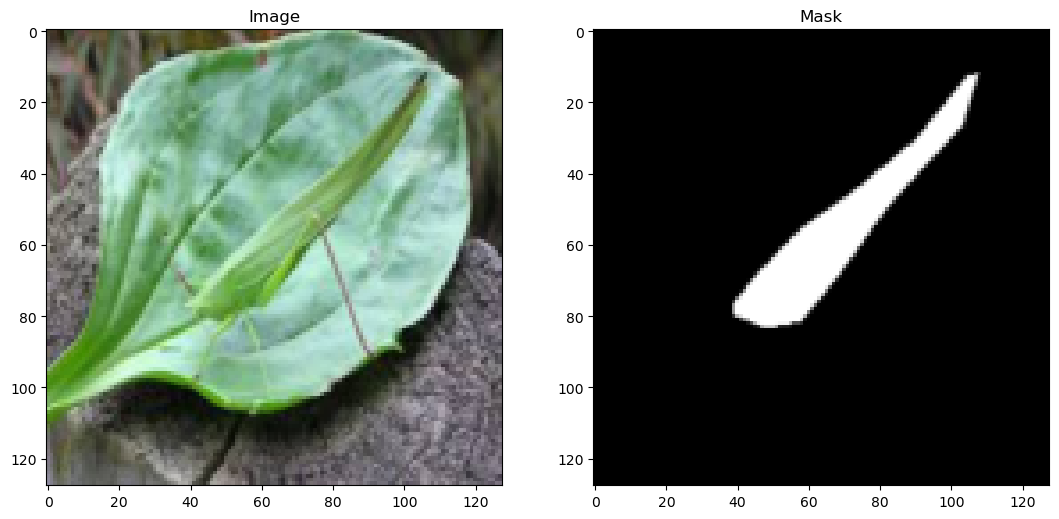

In [8]:
dataiter = iter(train_loader)
image, mask = next(dataiter)
index = 0
image_show(image[index], mask[index])

In [9]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [10]:
class DenseBlock(nn.Module):
    def __init__(self, channels: int, output_channels: int, depth = 4) -> None:
        super(DenseBlock, self).__init__()
        self.depth = depth
        self.norm=[]
        self.conv=[]
        for i in range(depth):
            self.conv.append(nn.Conv2d(channels+i*output_channels, output_channels, 1+((i//2)*2), 1, 'same', device=device))
            self.norm.append(nn.BatchNorm2d(output_channels, device=device))
        self.convFinal = nn.Conv2d(channels+depth*output_channels, channels, 1, device=device)
        self.normFinal = nn.BatchNorm2d(channels, device=device)
    
    def forward(self, x):
        for layer in range(self.depth):
            if layer == 0:
                temp = x
            x_temp = torch.relu(self.norm[layer](self.conv[layer](temp)))
            temp = torch.cat((temp, x_temp), 1)
        x = torch.relu(self.normFinal(self.convFinal(temp)))
        return x

In [11]:
class UNet(nn.Module):
    def __init__(self) -> None:
        super(UNet, self).__init__()

        # ENCODER
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 'same') # 128, 128, 3 --> 128, 128, 64
        self.norm1 = nn.BatchNorm2d(64)
        self.denseBlock1 = DenseBlock(64, 8, 8).to(device)

        self.maxpool1 = nn.MaxPool2d(2,2) # 100, 100, 64

        self.conv2 = nn.Conv2d(64, 128, 3, 1, 'same') # 100, 100, 64 --> 100, 100, 128
        self.norm2 = nn.BatchNorm2d(128)
        self.denseBlock2 = DenseBlock(128, 16, 8).to(device) # 100, 100, 128

        self.maxpool2 = nn.MaxPool2d(2,2) # 50, 50, 128

        self.conv3 = nn.Conv2d(128, 256, 3, 1, 'same') # 50, 50, 128 --> 50, 50, 256
        self.norm3 = nn.BatchNorm2d(256)
        self.denseBlock3 = DenseBlock(256, 32, 8).to(device) # 50, 50, 256

        self.maxpool3 = nn.MaxPool2d(2,2) # 25, 25, 256

        self.conv4 = nn.Conv2d(256, 512, 3, 1, 1) # 25, 25, 256 --> 25, 25, 512
        self.norm4 = nn.BatchNorm2d(512)
        self.denseBlock4 = DenseBlock(512, 64, 8).to(device) # 25, 25, 512


        # DECODER
        self.convT1 = nn.ConvTranspose2d(512, 256, 2, 2)

        self.denseBlock5 = DenseBlock(512, 64, 8).to(device)

        self.convT2 = nn.ConvTranspose2d(512, 128, 2, 2)

        self.denseBlock6 = DenseBlock(256, 32, 8).to(device)

        self.convT3 = nn.ConvTranspose2d(256, 64, 2, 2)

        self.denseBlock7 = DenseBlock(128, 16, 8).to(device)

        self.conv71 = nn.Conv2d(128, 64, 3, 1, 'same')
        self.norm71 = nn.BatchNorm2d(64)
        self.conv72 = nn.Conv2d(64, 16, 5, 1, 'same')
        self.norm72 = nn.BatchNorm2d(16)
        self.conv73 = nn.Conv2d(16, 1, 7, 1, 'same')
        self.norm73 = nn.BatchNorm2d(1)

    def forward(self, x):
        # ENCODER
        x = torch.relu(self.norm1(self.conv1(x)))
        x_temp1 = self.denseBlock1(x)

        x = self.maxpool1(x_temp1)

        x = torch.relu(self.norm2(self.conv2(x)))
        x_temp2 = self.denseBlock2(x)

        x = self.maxpool2(x_temp2)

        x = torch.relu(self.norm3(self.conv3(x)))
        x_temp3 = self.denseBlock3(x)

        x = self.maxpool3(x_temp3)

        x = torch.relu(self.norm4(self.conv4(x)))
        x = self.denseBlock4(x)

        # DECODER
        x = self.convT1(x)

        x = torch.cat((x,x_temp3), 1)

        x = self.denseBlock5(x)

        x = self.convT2(x)

        x = torch.cat((x,x_temp2), 1)

        x = self.denseBlock6(x)

        x = self.convT3(x)   

        x = torch.cat((x,x_temp1), 1)

        x = self.denseBlock7(x)

        x = torch.relu(self.norm71(self.conv71(x)))
        x = torch.relu(self.norm72(self.conv72(x)))
        x = torch.sigmoid(self.norm73(self.conv73(x)))

        return x

In [12]:
unet = UNet().to(device)
den = DenseBlock(1,1).to(device)

In [21]:
summary(copy.deepcopy(unet).to('cpu'), (3, 128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3         [-1, 64, 128, 128]           8,256
       BatchNorm2d-4         [-1, 64, 128, 128]             128
        DenseBlock-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
            Conv2d-9          [-1, 128, 64, 64]          32,896
      BatchNorm2d-10          [-1, 128, 64, 64]             256
       DenseBlock-11          [-1, 128, 64, 64]               0
        MaxPool2d-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-14          [-1, 256,

# Binary Cross Entropy Loss

In [13]:
criterion1 = nn.BCELoss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=4e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.5)

In [14]:
num_epochs = 10
batches = len(train_loader)
losses = []
print(batches)

16


In [15]:
tic = time.time()
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}; LR = {scheduler.get_last_lr()[0]}')
    for i, (images,masks) in enumerate(train_loader):
        images = images.to(device)
        masks = torch.round(masks).to(device)

        preds = unet.forward(images)
        loss = criterion1(preds, masks) + criterion2(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Step {i+1}/{batches}; Loss = {loss.item():.4f}')
        losses.append(loss.item())
    scheduler.step()
print('Finished Training!')
print(f'Time Taken = {(time.time() - tic)//60:.0f}m {(time.time() - tic)%60:.0f}s')

Epoch 1/10; LR = 0.4
Step 1/16; Loss = 1.0874
Step 2/16; Loss = 0.8288
Step 3/16; Loss = 0.6724
Step 4/16; Loss = 0.6133
Step 5/16; Loss = 0.6299
Step 6/16; Loss = 0.5644
Step 7/16; Loss = 0.6148
Step 8/16; Loss = 0.6461
Step 9/16; Loss = 0.5945
Step 10/16; Loss = 0.6038
Step 11/16; Loss = 0.5738
Step 12/16; Loss = 0.6597
Step 13/16; Loss = 0.6829
Step 14/16; Loss = 0.5974
Step 15/16; Loss = 0.6121
Step 16/16; Loss = 0.5903
Epoch 2/10; LR = 0.2
Step 1/16; Loss = 0.5337
Step 2/16; Loss = 0.5416
Step 3/16; Loss = 0.5416
Step 4/16; Loss = 0.5959
Step 5/16; Loss = 0.5537
Step 6/16; Loss = 0.5293
Step 7/16; Loss = 0.5047
Step 8/16; Loss = 0.4971
Step 9/16; Loss = 0.5203
Step 10/16; Loss = 0.5196
Step 11/16; Loss = 0.4887
Step 12/16; Loss = 0.5132
Step 13/16; Loss = 0.5090
Step 14/16; Loss = 0.5007
Step 15/16; Loss = 0.5449
Step 16/16; Loss = 0.4809
Epoch 3/10; LR = 0.1
Step 1/16; Loss = 0.4651
Step 2/16; Loss = 0.4637
Step 3/16; Loss = 0.4646
Step 4/16; Loss = 0.4366
Step 5/16; Loss = 0.486

In [25]:
torch.save(unet, '../models/U-Net_Image_Segmentation_IE643_Dense_Custom_Loss.pt')

In [19]:
unet = torch.load('../models/U-Net_Image_Segmentation_IE643_Dense_Custom_Loss.pt')
unet.eval()

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (denseBlock1): DenseBlock(
    (convFinal): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (normFinal): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (denseBlock2): DenseBlock(
    (convFinal): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (normFinal): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm3

In [20]:
threshold = 0.4

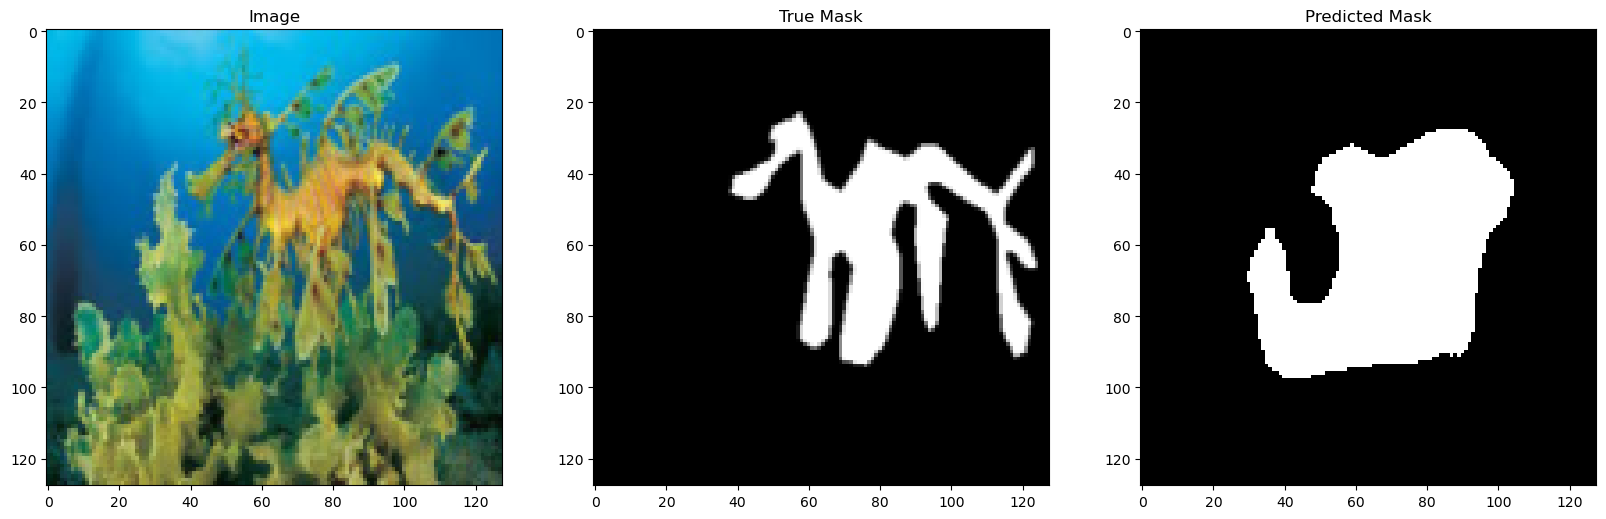

In [21]:
image, mask = next(iter(train_loader))
image = image.to(device)
mask = mask.to('cpu')
pred = unet(image).cpu()
pred1 = torch.relu(torch.sign(pred - threshold))
image = image.to('cpu')
image_show(image[0], mask[0], pred1[0])

In [22]:
IoU = JaccardIndex(num_classes=2)
IoU_value = 0
for image, mask in train_loader:
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred = torch.relu(torch.sign(pred - threshold)) # Taking 0.4 as the threshold to make the value 1
    IoU_value += IoU(pred, torch.round(mask).type(torch.int16)).item()
print(f'Intersection Over Union value = {IoU_value/len(train_loader)}')

Intersection Over Union value = 0.5794483870267868


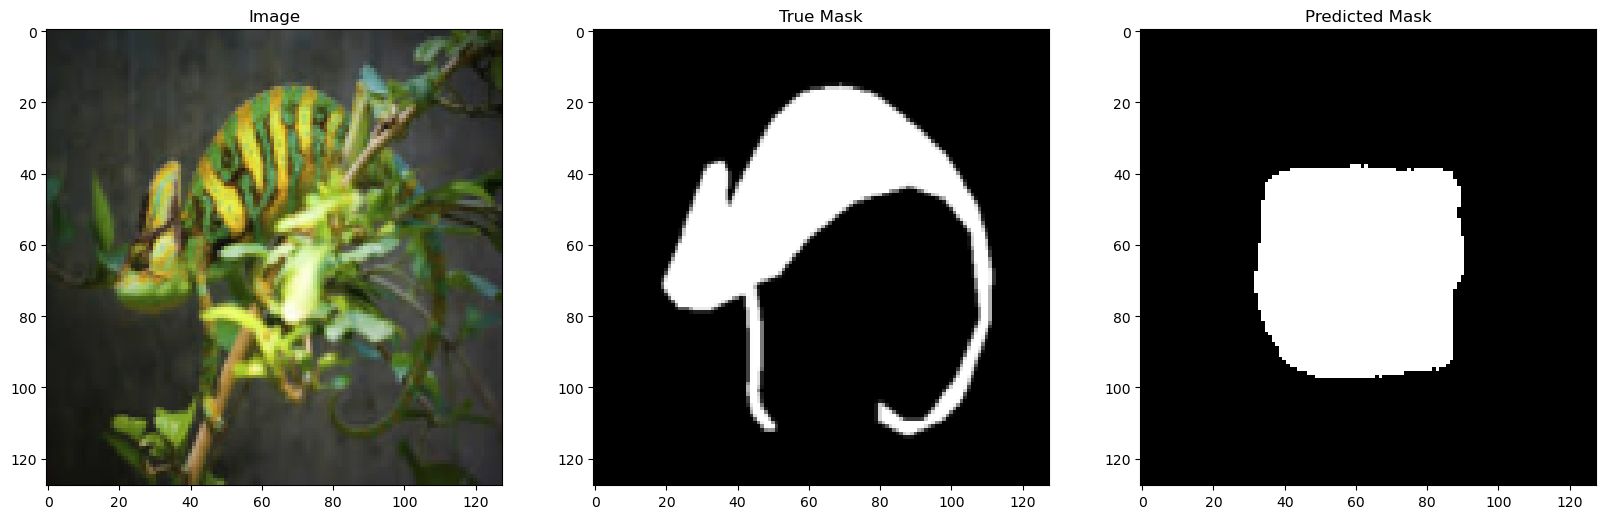

In [23]:
image, mask = next(iter(val_loader))
image = image.to(device)
mask = mask.to('cpu')
pred = unet(image).cpu()
pred1 = torch.relu(torch.sign(pred - threshold))
image = image.to('cpu')
image_show(image[0], mask[0], pred1[0])

In [24]:
IoU = JaccardIndex(num_classes=2)
IoU_value = 0
for image, mask in val_loader:
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred = pred = torch.relu(torch.sign(pred - threshold))
    IoU_value += IoU(pred, torch.round(mask).type(torch.int16)).item()
print(f'Intersection Over Union value = {IoU_value/len(val_loader)}')

Intersection Over Union value = 0.5657089203596115
